In [1]:
import requests
import pandas as pd
import geopandas as gpd
import json
from shapely import wkt, wkb
import polyline
from shapely.geometry import LineString

In [2]:
base_url = "https://maps.trimet.org/otp_mod/plan"
fromplace = "45.504286,-122.646199"
toplace = "45.542102,-122.664715"
date="2023-05-02"
time="12:00"
mode="WALK,BUS,TRAM,RAIL,GONDOLA"
maxWalkDistance=1609
walkSpeed=1.34
numItineraries=3
r = requests.get(url=base_url, params={'fromPlace':fromplace, 'toPlace':toplace, 'date':date, 'time':time
                                   ,'mode':mode, 'maxWalkDistance':maxWalkDistance, 'walkSpeed':walkSpeed
                                   ,'numItineraries':numItineraries})

In [3]:
r.status_code

200

In [21]:
json_content = r.json()
json_content

{'requestParameters': {'date': '2023-05-02',
  'mode': 'WALK,BUS,TRAM,RAIL,GONDOLA',
  'walkSpeed': '1.34',
  'fromPlace': '45.504286,-122.646199',
  'toPlace': '45.542102,-122.664715',
  'time': '12:00',
  'maxWalkDistance': '1609',
  'numItineraries': '3'},
 'plan': {'date': 1683054000000,
  'from': {'name': 'Origin',
   'wheelchairBoarding': 'UNKNOWN',
   'lon': -122.646199,
   'lat': 45.504286,
   'orig': '',
   'vertexType': 'NORMAL'},
  'to': {'name': 'Destination',
   'wheelchairBoarding': 'UNKNOWN',
   'lon': -122.664715,
   'lat': 45.542102,
   'orig': '',
   'vertexType': 'NORMAL'},
  'itineraries': [{'duration': 2409,
    'startTime': 1683054085000,
    'endTime': 1683056494000,
    'walkTime': 713,
    'transitTime': 1283,
    'waitingTime': 413,
    'walkDistance': 1007.4454626807768,
    'walkLimitExceeded': False,
    'elevationLost': 0.8899999999999979,
    'elevationGained': 11.54,
    'transfers': 1,
    'fare': {'fare': {'regular': {'currency': {'symbol': '$',
      

In [22]:
json_content['plan']['itineraries'][0]

{'duration': 2409,
 'startTime': 1683054085000,
 'endTime': 1683056494000,
 'walkTime': 713,
 'transitTime': 1283,
 'waitingTime': 413,
 'walkDistance': 1007.4454626807768,
 'walkLimitExceeded': False,
 'elevationLost': 0.8899999999999979,
 'elevationGained': 11.54,
 'transfers': 1,
 'fare': {'fare': {'regular': {'currency': {'symbol': '$',
     'currency': 'USD',
     'defaultFractionDigits': 2,
     'currencyCode': 'USD'},
    'cents': 450}},
  'details': {'regular': []}},
 'legs': [{'startTime': 1683054085000,
   'endTime': 1683054162000,
   'departureDelay': 0,
   'arrivalDelay': 0,
   'realTime': False,
   'distance': 69.472,
   'pathway': False,
   'mode': 'WALK',
   'route': '',
   'agencyTimeZoneOffset': -25200000,
   'interlineWithPreviousLeg': False,
   'from': {'name': 'Origin',
    'wheelchairBoarding': 'UNKNOWN',
    'lon': -122.646199,
    'lat': 45.504286,
    'departure': 1683054085000,
    'orig': '',
    'vertexType': 'NORMAL'},
   'to': {'name': 'SE Division & 20th A

In [23]:
route_id = json_content['plan']['itineraries'][1]['legs'][1]['routeId'].split(":")[-1]
route_id

'2'

In [24]:
json_content['plan']['itineraries'][1]['legs'][1]['from']

{'name': 'SE Division & 20th Ave',
 'stopId': 'TriMet:14243',
 'wheelchairBoarding': 'UNKNOWN',
 'stopCode': '14243',
 'lon': -122.645979,
 'lat': 45.504888,
 'arrival': 1683054162000,
 'departure': 1683054163000,
 'zoneId': 'B',
 'stopIndex': 31,
 'stopSequence': 33,
 'vertexType': 'TRANSIT',
 'boardAlightType': 'DEFAULT'}

In [26]:
json_content['plan']['itineraries'][1]['legs'][1]['to']

{'name': 'SW 6th & Taylor',
 'stopId': 'TriMet:7800',
 'wheelchairBoarding': 'UNKNOWN',
 'stopCode': '7800',
 'lon': -122.679316,
 'lat': 45.517604,
 'arrival': 1683055200000,
 'departure': 1683055200000,
 'zoneId': 'B',
 'stopIndex': 38,
 'stopSequence': 40,
 'vertexType': 'TRANSIT',
 'boardAlightType': 'DEFAULT'}

path for that leg

In [27]:
polyline.decode(json_content['plan']['itineraries'][1]['legs'][1]['legGeometry']['points'])[:10]

[(45.50482, -122.64601),
 (45.50482, -122.64607),
 (45.50483, -122.6469),
 (45.50483, -122.64765),
 (45.50483, -122.64856),
 (45.50483, -122.64867),
 (45.50483, -122.64875),
 (45.50483, -122.64944),
 (45.50484, -122.64968),
 (45.50484, -122.65069)]

In [28]:
len(polyline.decode(json_content['plan']['itineraries'][1]['legs'][1]['legGeometry']['points']))

278

In [49]:
reformatted_coords = []
original_coords = polyline.decode(json_content['plan']['itineraries'][1]['legs'][1]['legGeometry']['points'])
for coord in original_coords:
    reformatted_coords.append((coord[1],coord[0]))

reformatted_coords[:5]

[(-122.64601, 45.50482),
 (-122.64607, 45.50482),
 (-122.6469, 45.50483),
 (-122.64765, 45.50483),
 (-122.64856, 45.50483)]

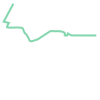

In [50]:
path_geometry = LineString(reformatted_coords)
path_geometry

In [51]:
path_gdf = gpd.GeoDataFrame(pd.DataFrame([route_id],columns=['route_id']), crs="4326", geometry=[path_geometry])
path_gdf

,route_id,geometry
0,2,"LINESTRING (-122.64601 45.50482, -122.64607 45..."


In [52]:
path_gdf.explore()

In [28]:
path_gdf.to_file("test.geojson", driver="GeoJSON")

In [21]:
winning_dict = {}
for idx, itinerary in enumerate(json_content['plan']['itineraries']):
    winning_combos = []
    for leg in itinerary['legs']:
        if leg['mode'] != 'WALK':
            winning_combos.append((leg['mode'],leg['route']))
    winning_dict[idx] = winning_combos

In [22]:
winning_dict

{0: [('BUS', 'FX2'), ('TRAM', 'Portland Streetcar - B Loop')],
 1: [('BUS', 'FX2'), ('BUS', '4')],
 2: [('BUS', '10'), ('BUS', '6')]}

In [12]:
for leg in json_content['plan']['itineraries'][0]['legs']:
    print(leg['mode'])

WALK
BUS
WALK
BUS
WALK


In [13]:
json_content['plan']['itineraries'][0]['legs'][1]

{'startTime': 1683054163000,
 'endTime': 1683055200000,
 'departureDelay': 0,
 'arrivalDelay': 0,
 'realTime': False,
 'distance': 4811.395650329354,
 'pathway': False,
 'mode': 'BUS',
 'route': 'FX2',
 'agencyName': 'TriMet',
 'agencyUrl': 'https://trimet.org/',
 'agencyTimeZoneOffset': -25200000,
 'routeColor': '61A60E',
 'routeType': 3,
 'routeId': 'TriMet:2',
 'routeTextColor': 'FFFFFF',
 'interlineWithPreviousLeg': False,
 'tripBlockId': '253',
 'headsign': 'Portland',
 'agencyId': 'TRIMET',
 'tripId': 'TriMet:12336945',
 'serviceDate': '20230502',
 'from': {'name': 'SE Division & 20th Ave',
  'stopId': 'TriMet:14243',
  'wheelchairBoarding': 'UNKNOWN',
  'stopCode': '14243',
  'lon': -122.645979,
  'lat': 45.504888,
  'arrival': 1683054162000,
  'departure': 1683054163000,
  'zoneId': 'B',
  'stopIndex': 31,
  'stopSequence': 33,
  'vertexType': 'TRANSIT',
  'boardAlightType': 'DEFAULT'},
 'to': {'name': 'SW 6th & Taylor',
  'stopId': 'TriMet:7800',
  'wheelchairBoarding': 'UNKNO

In [8]:
json_content['plan']['itineraries'][0]['legs'][1]['legGeometry']['points']

'ctvtGphqkV?JAdD?tC?tD?T?N?hCAn@?hE?jE?P?XA|C?hE?T?\\AxC?P?~@AvB?T?NANAJAJCFENOZs@zAKDWh@?LMZKVR@FBDBDDTRDDTPHFLFD?XG?zDyCAU@G?I@GDC@CBILKVM\\Qd@IZK^I`@I^EXEZEZC\\CZ?VCX?T?V?|A?j@@T?V?PAhEAr@?hAAFCN?F?b@?X@J@NDTBJDNDH@FFJJPZh@`@r@n@jAx@tAt@rA~@`Bx@xAvBvDfAlBf@z@HNFJ@DDHFNFPDRFPDNBHDRBHHXHZFTJj@|@jEH`@BNAL?HA\\?D?D?HAFAH?FAFCFCFINEFCDC@CBC@IBaBp@y@ZiA`@_@PWJOHOHq@\\OHQHc@TSLKHOJEDGFGDo@r@EFMLQPGDQLMHEBGBKDQHIBqAb@CBKBQFG@SDI@s@NODE@MDGDGBEDGDEDEBEFGHEHEDEHCHCDGTIZAHAHAJ?HAJ?J?DAL?H?R?nB?BCTATAvC?X@N@^@ZBl@@fA?J?`@?N?^?bA?\\AjB?XA\\AXC^Eb@AHCNALK?Y?m@EQAUGSG]MGCWMKE}@a@y@]KGQ`AMv@Mn@G\\ADq@|DCNaAc@MGs@[yBaAMG{BcAGCgBw@EAUMGA{@a@aAc@mBy@?AWKcCgAeCgAKEmBu@MEMIkBy@IEQG{Aq@'

In [7]:
polyline.decode(json_content['plan']['itineraries'][0]['legs'][1]['legGeometry']['points'])

[(45.50482, -122.64601),
 (45.50482, -122.64607),
 (45.50483, -122.6469),
 (45.50483, -122.64765),
 (45.50483, -122.64856),
 (45.50483, -122.64867),
 (45.50483, -122.64875),
 (45.50483, -122.64944),
 (45.50484, -122.64968),
 (45.50484, -122.65069),
 (45.50484, -122.65171),
 (45.50484, -122.6518),
 (45.50484, -122.65193),
 (45.50485, -122.65272),
 (45.50485, -122.65373),
 (45.50485, -122.65384),
 (45.50485, -122.65399),
 (45.50486, -122.65476),
 (45.50486, -122.65485),
 (45.50486, -122.65517),
 (45.50487, -122.65577),
 (45.50487, -122.65588),
 (45.50487, -122.65596),
 (45.50488, -122.65604),
 (45.50489, -122.6561),
 (45.5049, -122.65616),
 (45.50492, -122.6562),
 (45.50495, -122.65628),
 (45.50503, -122.65642),
 (45.50529, -122.65688),
 (45.50535, -122.65691),
 (45.50547, -122.65712),
 (45.50547, -122.65719),
 (45.50554, -122.65733),
 (45.5056, -122.65745),
 (45.5055, -122.65746),
 (45.50546, -122.65748),
 (45.50543, -122.6575),
 (45.5054, -122.65753),
 (45.50529, -122.65763),
 (45.5052

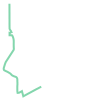

In [10]:
LineString(polyline.decode(json_content['plan']['itineraries'][0]['legs'][1]['legGeometry']['points']))